In [1]:
import geopandas as gpd
import pandas as pd

import mapillary as mly
import json

import glob




### netzwerk einlesen

In [2]:

#set_date = "250805" 
set_date = "250908" 

cycleways=gpd.read_parquet(f"processed_osm_files/processed_cycleways_germany_{set_date}.parquet")
motorways=gpd.read_parquet(f"processed_osm_files/processed_motorways_germany_{set_date}.parquet")



In [3]:
len(cycleways)

7473102

In [4]:
len(motorways)

69629

In [5]:
cycleways.columns

Index(['osm_id', 'highway', 'bicycle', 'bicycle_forward', 'bicycle_backward',
       'cycleway', 'cycleway_left', 'cycleway_right', 'cycleway_both',
       'cycleway_lane', 'cycleway_track', 'cycleway_opposite',
       'cycleway_shared_lane', 'sidewalk_right_bicycle',
       'sidewalk_left_bicycle', 'sidewalk_both_bicycle', 'maxspeed',
       'maxspeed_conditional', 'maxspeed_backward', 'maxspeed_forward',
       'maxspeed_type', 'name', 'ref', 'surface', 'width', 'geometry'],
      dtype='object')

In [6]:
filtered_cycleways = cycleways[
    (cycleways["bicycle"].isin(["designated"])) |
    (cycleways["bicycle_backward"].isin(["designated"])) |
    (cycleways["bicycle_forward"].isin(["designated"])) |
    (cycleways["highway"].isin(["cycleway"])) |
    (cycleways["cycleway"].notnull() & (cycleways["cycleway"] != "no")) |
    (cycleways["cycleway_left"].notnull() & (cycleways["cycleway_left"] != "no")) |
    (cycleways["cycleway_right"].notnull() & (cycleways["cycleway_right"] != "no")) |
    (cycleways["cycleway_both"].notnull() & (cycleways["cycleway_both"] != "no")) |
    (cycleways["cycleway_lane"].notnull() & (cycleways["cycleway_lane"] != "no")) |
    (cycleways["cycleway_track"].notnull() & (cycleways["cycleway_track"] != "no")) |
    # (cycleways["sidewalk"].isin(["designated"])) |  TODO: add "sidewalk" in ini file
    (cycleways["sidewalk_right_bicycle"].isin(["designated"])) |
    (cycleways["sidewalk_left_bicycle"].isin(["designated"])) |
    (cycleways["sidewalk_both_bicycle"].isin(["designated"])) 
]
len(filtered_cycleways)

754173

In [7]:
filtered_cycleways.highway.value_counts()

highway
path                                      310390
secondary                                 113887
cycleway                                   88419
tertiary                                   79124
primary                                    60808
residential                                42431
footway                                    18678
unclassified                               12148
track                                      11969
service                                     7140
secondary_link                              1640
living_street                               1629
primary_link                                1390
tertiary_link                                935
construction                                 757
trunk                                        650
trunk_link                                   581
pedestrian                                   579
steps                                        291
proposed                                      94
motorway_lin

In [ ]:


## TRAFFFIC SIGNS
# https://www.mapillary.com/developer/api-documentation/traffic-signs?locale=

# Unterschiedliche Verkehrszeichen in Deutschland für Radwege

# https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:237
de_237="regulatory--bicycles-only--g1"

# https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:240
de_240="regulatory--shared-path-pedestrians-and-bicycles--g1"

# https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:241-30
de_241_30="regulatory--dual-path-bicycles-and-pedestrians--g1"

# https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:241-31
de_241_31="regulatory--dual-path-pedestrians-and-bicycles--g1"


# ggf. noch  "complementary--except-bicycles--g1" https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:1022-10



#mapillary_trafficsigns = gpd.read_parquet("../preprocessing/mapillary_map-feature-data_ger_2025-06-07.parquet") ## -> 184120 features
#mapillary_trafficsigns = gpd.read_parquet("../preprocessing/mapillary_map-feature-data_ger_2025-07-30.parquet") ## -> 213732 features
#                                                                                          _2025-08-05.       ") ## -> 214438 features
#                                                                                          _2025-09-08.       ") ## -> 220510 features


# Find all parquet files in the tile_cache folder (per state)
parquet_files = glob.glob("../../output/*.parquet")

# Read all files and concatenate into one GeoDataFrame
mapillary_trafficsigns = gpd.GeoDataFrame(
    pd.concat([gpd.read_parquet(f) for f in parquet_files], ignore_index=True),
    crs=gpd.read_parquet(parquet_files[0]).crs
)






# Schilder in Germany
mapillary_trafficsigns_cw=mapillary_trafficsigns[mapillary_trafficsigns.value.isin([de_237, de_240, de_241_30, de_241_31])]

mapillary_trafficsigns_cw=mapillary_trafficsigns_cw.drop_duplicates(subset=['id'])


mapillary_trafficsigns_cw

,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y
246,POINT (7.55549 47.81129),2020-06-12,506659373860596,2020-06-12,regulatory--bicycles-only--g1,8535,5708
289,POINT (7.55567 47.81125),2021-07-17,501219351158581,2025-08-16,regulatory--shared-path-pedestrians-and-bicycl...,8535,5708
316,POINT (7.5555 47.81114),2020-06-12,4133683286689254,2020-06-12,regulatory--shared-path-pedestrians-and-bicycl...,8535,5708
402,POINT (7.55555 47.78557),2022-05-02,1867537346789430,2022-05-02,regulatory--shared-path-pedestrians-and-bicycl...,8535,5709
445,POINT (7.55503 47.78421),2019-05-27,2641234709510010,2019-05-27,regulatory--shared-path-pedestrians-and-bicycl...,8535,5709
...,...,...,...,...,...,...,...
6217310,POINT (14.69721 51.98872),2020-06-08,1192699094494300,2020-06-08,regulatory--shared-path-pedestrians-and-bicycl...,8860,5412
6217321,POINT (14.67975 51.95704),2024-09-06,884164249839890,2024-09-06,regulatory--dual-path-bicycles-and-pedestrians...,8860,5415
6217397,POINT (14.70382 51.61588),2024-07-04,384818727480799,2024-07-04,regulatory--shared-path-pedestrians-and-bicycl...,8861,5440
6217401,POINT (14.70519 51.61576),2024-06-28,895241345696723,2024-06-28,regulatory--shared-path-pedestrians-and-bicycl...,8861,5440


In [9]:
##  newer than 2025-01-01

mapillary_trafficsigns_cw=mapillary_trafficsigns_cw[mapillary_trafficsigns_cw["last_seen_at"] > "2025-01-01"]
# mapillary_trafficsigns_237_recent

In [10]:
from datetime import datetime

##  at least 12 months between first and last seen (to avoid temporary signs)
## might need to adjust this

def months_between(date1, date2):
    d1 = datetime.strptime(date1, "%Y-%m-%d")
    d2 = datetime.strptime(date2, "%Y-%m-%d")
    return abs((d2.year - d1.year) * 12 + d2.month - d1.month)

mapillary_trafficsigns_cw_temp = mapillary_trafficsigns_cw[
    mapillary_trafficsigns_cw.apply(lambda row: months_between(row['first_seen_at'], row['last_seen_at']) >= 12, axis=1)
]
mapillary_trafficsigns_cw_temp

,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y
289,POINT (7.55567 47.81125),2021-07-17,501219351158581,2025-08-16,regulatory--shared-path-pedestrians-and-bicycl...,8535,5708
1014,POINT (7.55959 47.82204),2023-04-10,1464772837664257,2025-08-16,regulatory--shared-path-pedestrians-and-bicycl...,8536,5707
1143,POINT (7.5671 47.82198),2023-04-10,893821328391590,2025-08-16,regulatory--shared-path-pedestrians-and-bicycl...,8536,5707
1380,POINT (7.5608 47.823),2023-04-10,1464772877664253,2025-08-16,regulatory--shared-path-pedestrians-and-bicycl...,8536,5707
3654,POINT (7.59929 47.81091),2024-05-26,1158881182119911,2025-08-16,regulatory--shared-path-pedestrians-and-bicycl...,8537,5708
...,...,...,...,...,...,...,...
6216911,POINT (14.66349 52.13952),2020-09-13,1337643519969373,2025-02-06,regulatory--dual-path-bicycles-and-pedestrians...,8859,5401
6216927,POINT (14.66507 52.14069),2020-09-13,472013520755904,2025-07-14,regulatory--dual-path-bicycles-and-pedestrians...,8859,5401
6216939,POINT (14.66975 52.14472),2020-09-13,278103970705311,2025-07-04,regulatory--dual-path-bicycles-and-pedestrians...,8859,5401
6216973,POINT (14.65941 52.14051),2020-09-13,136186158462617,2025-02-06,regulatory--shared-path-pedestrians-and-bicycl...,8859,5401


<Axes: >

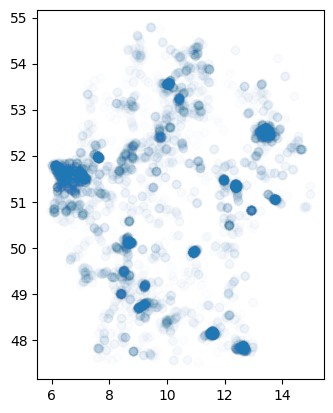

In [11]:
mapillary_trafficsigns_cw_temp.plot(alpha=0.01)

In [12]:
## now create a buffer around the traffic signs to check if there is a cycleway nearby
df_buffered = mapillary_trafficsigns_cw_temp.to_crs(25833).copy()
df_buffered["geometry"] = df_buffered.geometry.buffer(50)
df_buffered = df_buffered.to_crs(mapillary_trafficsigns_cw_temp.crs)


In [13]:
import geopandas as gpd

def mark_intersections(buffered_df, target_layer, column_name="has_intersection"):
    """
    Marks which geometries in `buffered_df` intersect with `target_layer`.

    Parameters:
    - buffered_df (GeoDataFrame): The GeoDataFrame containing buffered geometries.
    - target_layer (GeoDataFrame): The GeoDataFrame to check for intersections (e.g., cycleways, motorways).
    - column_name (str): Name of the column to add/overwrite in `buffered_df` indicating intersection (bool).

    Returns:
    - GeoDataFrame: `buffered_df` with a new boolean column `column_name`.
    """
    # Ensure CRS matches
    buffered_df = buffered_df.to_crs(target_layer.crs)

    # Perform spatial join to find intersecting geometries
    joined = gpd.sjoin(buffered_df, target_layer, how="inner", predicate="intersects")

    # Initialize the new column to False
    buffered_df[column_name] = False

    # Set True for geometries that intersect
    matches = joined.index.unique()
    buffered_df.loc[matches, column_name] = True

    return buffered_df


In [14]:
# For cycleways
df_buffered = mark_intersections(df_buffered, filtered_cycleways, column_name="has_cw_intersection")

# For motorways
df_buffered = mark_intersections(df_buffered, motorways, column_name="has_mw_intersection")


In [15]:
df_buffered

,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y,has_cw_intersection,has_mw_intersection
289,"POLYGON ((7.55633 47.8113, 7.55634 47.81125, 7...",2021-07-17,501219351158581,2025-08-16,regulatory--shared-path-pedestrians-and-bicycl...,8535,5708,True,False
1014,"POLYGON ((7.56025 47.82208, 7.56025 47.82204, ...",2023-04-10,1464772837664257,2025-08-16,regulatory--shared-path-pedestrians-and-bicycl...,8536,5707,True,False
1143,"POLYGON ((7.56776 47.82202, 7.56777 47.82198, ...",2023-04-10,893821328391590,2025-08-16,regulatory--shared-path-pedestrians-and-bicycl...,8536,5707,True,False
1380,"POLYGON ((7.56147 47.82304, 7.56147 47.823, 7....",2023-04-10,1464772877664253,2025-08-16,regulatory--shared-path-pedestrians-and-bicycl...,8536,5707,True,False
3654,"POLYGON ((7.59995 47.81095, 7.59995 47.81091, ...",2024-05-26,1158881182119911,2025-08-16,regulatory--shared-path-pedestrians-and-bicycl...,8537,5708,True,False
...,...,...,...,...,...,...,...,...,...
6216911,"POLYGON ((14.66422 52.13952, 14.66422 52.13948...",2020-09-13,1337643519969373,2025-02-06,regulatory--dual-path-bicycles-and-pedestrians...,8859,5401,True,False
6216927,"POLYGON ((14.6658 52.14069, 14.6658 52.14065, ...",2020-09-13,472013520755904,2025-07-14,regulatory--dual-path-bicycles-and-pedestrians...,8859,5401,True,False
6216939,"POLYGON ((14.67048 52.14472, 14.67047 52.14468...",2020-09-13,278103970705311,2025-07-04,regulatory--dual-path-bicycles-and-pedestrians...,8859,5401,True,False
6216973,"POLYGON ((14.66015 52.14052, 14.66014 52.14047...",2020-09-13,136186158462617,2025-02-06,regulatory--shared-path-pedestrians-and-bicycl...,8859,5401,True,False


In [16]:


# Step 2: Ensure CRS matches
df_buffered = df_buffered.to_crs(filtered_cycleways.crs)

# Step 3: Perform spatial join (find intersecting geometries)
joined = gpd.sjoin(df_buffered, filtered_cycleways, how="inner", predicate="intersects")

# # Step 4: Mark which polygons had at least one intersection
# df_6months_30_buffered["has_30_intersection"] = df_6months_30_buffered.index.isin(joined.index)

# Zeilen, die mindestens einen Match haben
matches = joined.index.unique()

# Standardmäßig alles auf False setzen
df_buffered["has_cw_intersection"] = False

# Nur die gematchten Indizes auf True setzen
df_buffered.loc[matches, "has_cw_intersection"] = True



In [17]:
#df_buffered.id.unique()

In [18]:
df_buffered.has_cw_intersection.value_counts()

has_cw_intersection
True     13549
False      150
Name: count, dtype: int64

In [19]:
df_buffered.has_mw_intersection.value_counts()

has_mw_intersection
False    13556
True       143
Name: count, dtype: int64

In [20]:
((df_buffered.has_mw_intersection == False) & (df_buffered.has_cw_intersection == False)).sum()

np.int64(97)

In [21]:
df_buffered_false=df_buffered[(df_buffered.has_cw_intersection== False) & (df_buffered.has_mw_intersection== False)].copy()

In [22]:
df_buffered_false.explore(
    color="red",
    tiles="CartoDB positron",
    popup=True,
    tooltip=["value", "first_seen_at", "last_seen_at"]
)

In [23]:
df_buffered_false


,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y,has_cw_intersection,has_mw_intersection
14090,"POLYGON ((7.71597 48.24413, 7.71597 48.24409, ...",2019-05-26,476717333599437,2025-06-21,regulatory--shared-path-pedestrians-and-bicycl...,8543,5678,False,False
75758,"POLYGON ((8.2536 48.13199, 8.25361 48.13195, 8...",2021-08-21,949059759275532,2025-07-14,regulatory--shared-path-pedestrians-and-bicycl...,8567,5686,False,False
275951,"POLYGON ((8.68722 48.90625, 8.68722 48.90621, ...",2016-10-18,178120247414430,2025-06-20,regulatory--shared-path-pedestrians-and-bicycl...,8587,5633,False,False
434502,"POLYGON ((9.14037 49.19401, 9.14037 49.19396, ...",2022-06-26,139976915314841,2025-08-24,regulatory--shared-path-pedestrians-and-bicycl...,8607,5613,False,False
448355,"POLYGON ((9.15508 49.19801, 9.15509 49.19796, ...",2022-06-26,363016489195318,2025-08-24,regulatory--shared-path-pedestrians-and-bicycl...,8608,5612,False,False
...,...,...,...,...,...,...,...,...,...
5756646,"POLYGON ((10.38002 53.81164, 10.38002 53.8116,...",2024-06-05,306180939216811,2025-08-12,regulatory--dual-path-bicycles-and-pedestrians...,8664,5275,False,False
5762828,"POLYGON ((10.49457 54.19789, 10.49458 54.19784...",2022-08-09,957624968969058,2025-07-04,regulatory--shared-path-pedestrians-and-bicycl...,8669,5245,False,False
5766538,"POLYGON ((10.56136 54.20185, 10.56136 54.2018,...",2024-04-18,1112871083092969,2025-05-06,regulatory--shared-path-pedestrians-and-bicycl...,8672,5244,False,False
5809119,"POLYGON ((10.95606 54.37843, 10.95606 54.37839...",2018-02-26,213560316984978,2025-08-16,regulatory--shared-path-pedestrians-and-bicycl...,8690,5231,False,False


In [24]:
## retrieve the image ID for the map features

In [25]:
import sys
import os
import json
import logging
from contextlib import contextmanager
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

# -- suppress stdout context manager --
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

# -- Load config & set Mapillary token --
with open("config_mapillary_privat.json", "r") as f:
    config = json.load(f)

access_token = config["ACCESS_TOKEN"]
mly.interface.set_access_token(access_token)

# -- Logging cleanup --
for name in logging.root.manager.loggerDict:
    logging.getLogger(name).setLevel(logging.WARNING)
logging.basicConfig(level=logging.ERROR)

# -- Your image fetching function --
def get_image_id(map_feature_id):
    try:
        feature_str = mly.interface.feature_from_key(key=str(map_feature_id))
        feature = json.loads(feature_str)
        images = feature["features"]["properties"]["images"]["data"]
        return images[-1]["id"] if images else None
    except Exception as e:
        return None  # Or log the error if needed

# -- Parallelized version using ThreadPoolExecutor --
def parallel_get_image_ids(ids, max_workers=8):
    results = [None] * len(ids)

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(get_image_id, id_): idx for idx, id_ in enumerate(ids)}
        for future in tqdm(as_completed(futures), total=len(futures), desc="Fetching image IDs"):
            idx = futures[future]
            try:
                results[idx] = future.result()
            except Exception:
                results[idx] = None  # Or log
    return results

# -- Apply to your dataframe --
with suppress_stdout():
    df_buffered_false["image_id"] = parallel_get_image_ids(df_buffered_false["id"].tolist(), max_workers=5)  # Adjust max_workers as needed, 5 is fastest for me


Fetching image IDs: 100%|██████████| 97/97 [00:18<00:00,  5.12it/s]


In [26]:
df_buffered_false

,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y,has_cw_intersection,has_mw_intersection,image_id
14090,"POLYGON ((7.71597 48.24413, 7.71597 48.24409, ...",2019-05-26,476717333599437,2025-06-21,regulatory--shared-path-pedestrians-and-bicycl...,8543,5678,False,False,1908724709284962
75758,"POLYGON ((8.2536 48.13199, 8.25361 48.13195, 8...",2021-08-21,949059759275532,2025-07-14,regulatory--shared-path-pedestrians-and-bicycl...,8567,5686,False,False,237344198264857
275951,"POLYGON ((8.68722 48.90625, 8.68722 48.90621, ...",2016-10-18,178120247414430,2025-06-20,regulatory--shared-path-pedestrians-and-bicycl...,8587,5633,False,False,162731259001092
434502,"POLYGON ((9.14037 49.19401, 9.14037 49.19396, ...",2022-06-26,139976915314841,2025-08-24,regulatory--shared-path-pedestrians-and-bicycl...,8607,5613,False,False,190273640015755
448355,"POLYGON ((9.15508 49.19801, 9.15509 49.19796, ...",2022-06-26,363016489195318,2025-08-24,regulatory--shared-path-pedestrians-and-bicycl...,8608,5612,False,False,138650428814826
...,...,...,...,...,...,...,...,...,...,...
5756646,"POLYGON ((10.38002 53.81164, 10.38002 53.8116,...",2024-06-05,306180939216811,2025-08-12,regulatory--dual-path-bicycles-and-pedestrians...,8664,5275,False,False,992885039216443
5762828,"POLYGON ((10.49457 54.19789, 10.49458 54.19784...",2022-08-09,957624968969058,2025-07-04,regulatory--shared-path-pedestrians-and-bicycl...,8669,5245,False,False,1140631833500903
5766538,"POLYGON ((10.56136 54.20185, 10.56136 54.2018,...",2024-04-18,1112871083092969,2025-05-06,regulatory--shared-path-pedestrians-and-bicycl...,8672,5244,False,False,1189959148958755
5809119,"POLYGON ((10.95606 54.37843, 10.95606 54.37839...",2018-02-26,213560316984978,2025-08-16,regulatory--shared-path-pedestrians-and-bicycl...,8690,5231,False,False,522767959102276


In [27]:
centroids = df_buffered_false.copy()
centroids=centroids.to_crs(25832)
centroids["geometry"] = centroids.geometry.centroid
centroids=centroids.to_crs(4326)

centroids

,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y,has_cw_intersection,has_mw_intersection,image_id
14090,POINT (7.7153 48.24409),2019-05-26,476717333599437,2025-06-21,regulatory--shared-path-pedestrians-and-bicycl...,8543,5678,False,False,1908724709284962
75758,POINT (8.25294 48.13195),2021-08-21,949059759275532,2025-07-14,regulatory--shared-path-pedestrians-and-bicycl...,8567,5686,False,False,237344198264857
275951,POINT (8.68654 48.90622),2016-10-18,178120247414430,2025-06-20,regulatory--shared-path-pedestrians-and-bicycl...,8587,5633,False,False,162731259001092
434502,POINT (9.13969 49.19397),2022-06-26,139976915314841,2025-08-24,regulatory--shared-path-pedestrians-and-bicycl...,8607,5613,False,False,190273640015755
448355,POINT (9.1544 49.19797),2022-06-26,363016489195318,2025-08-24,regulatory--shared-path-pedestrians-and-bicycl...,8608,5612,False,False,138650428814826
...,...,...,...,...,...,...,...,...,...,...
5756646,POINT (10.37926 53.81161),2024-06-05,306180939216811,2025-08-12,regulatory--dual-path-bicycles-and-pedestrians...,8664,5275,False,False,992885039216443
5762828,POINT (10.49381 54.19786),2022-08-09,957624968969058,2025-07-04,regulatory--shared-path-pedestrians-and-bicycl...,8669,5245,False,False,1140631833500903
5766538,POINT (10.56059 54.20182),2024-04-18,1112871083092969,2025-05-06,regulatory--shared-path-pedestrians-and-bicycl...,8672,5244,False,False,1189959148958755
5809119,POINT (10.95529 54.37841),2018-02-26,213560316984978,2025-08-16,regulatory--shared-path-pedestrians-and-bicycl...,8690,5231,False,False,522767959102276


In [28]:
# Mapping dictionary
value_to_vz = {
    'regulatory--dual-path-pedestrians-and-bicycles--g1': 241,
    'regulatory--dual-path-bicycles-and-pedestrians--g1': 241,
    'regulatory--bicycles-only--g1': 237,
    'regulatory--shared-path-pedestrians-and-bicycles--g1': 240
}

# Add new column based on mapping
centroids["VZ"] = centroids["value"].map(value_to_vz)

In [29]:
centroids

,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y,has_cw_intersection,has_mw_intersection,image_id,VZ
14090,POINT (7.7153 48.24409),2019-05-26,476717333599437,2025-06-21,regulatory--shared-path-pedestrians-and-bicycl...,8543,5678,False,False,1908724709284962,240
75758,POINT (8.25294 48.13195),2021-08-21,949059759275532,2025-07-14,regulatory--shared-path-pedestrians-and-bicycl...,8567,5686,False,False,237344198264857,240
275951,POINT (8.68654 48.90622),2016-10-18,178120247414430,2025-06-20,regulatory--shared-path-pedestrians-and-bicycl...,8587,5633,False,False,162731259001092,240
434502,POINT (9.13969 49.19397),2022-06-26,139976915314841,2025-08-24,regulatory--shared-path-pedestrians-and-bicycl...,8607,5613,False,False,190273640015755,240
448355,POINT (9.1544 49.19797),2022-06-26,363016489195318,2025-08-24,regulatory--shared-path-pedestrians-and-bicycl...,8608,5612,False,False,138650428814826,240
...,...,...,...,...,...,...,...,...,...,...,...
5756646,POINT (10.37926 53.81161),2024-06-05,306180939216811,2025-08-12,regulatory--dual-path-bicycles-and-pedestrians...,8664,5275,False,False,992885039216443,241
5762828,POINT (10.49381 54.19786),2022-08-09,957624968969058,2025-07-04,regulatory--shared-path-pedestrians-and-bicycl...,8669,5245,False,False,1140631833500903,240
5766538,POINT (10.56059 54.20182),2024-04-18,1112871083092969,2025-05-06,regulatory--shared-path-pedestrians-and-bicycl...,8672,5244,False,False,1189959148958755,240
5809119,POINT (10.95529 54.37841),2018-02-26,213560316984978,2025-08-16,regulatory--shared-path-pedestrians-and-bicycl...,8690,5231,False,False,522767959102276,240


In [30]:
import uuid

def to_maproulette_geojson_with_links(gdf, id_field="id", name_field="value", image_field="image_id"):
    features = []

    for _, row in gdf.iterrows():
        geom = row.geometry
        centroid = geom.centroid
        lat, lon = round(centroid.y, 6), round(centroid.x, 6)

        # Optional: Mapillary image
        image_url = None
        image_id = None
        if pd.notna(row.get(image_field)):
            image_id = str(int(row[image_field]))
            image_url = (
                f"https://www.mapillary.com/app/?pKey={image_id}"
                "&focus=photo"
                "&trafficSign[]=regulatory--bicycles-only--g1"
                "&trafficSign[]=regulatory--shared-path-pedestrians-and-bicycles--g1"
                "&trafficSign[]=regulatory--dual-path-bicycles-and-pedestrians--g1"
                "&trafficSign[]=regulatory--dual-path-pedestrians-and-bicycles--g1"
            )

        # TILDA link
        tilda_url = f"https://tilda-geo.de/regionen/radinfra?map=17.4/{lat}/{lon}&config=pdqyyt.7h3d.16g9vk&v=2"

#         # Build instruction
        instruction = f"""  
### 🚧 Aufgabe: Verkehrszeichen **DE:{row["VZ"]}** überprüfen und Radinfra hinzufügen
Bitte schaue dir den Bereich rund um dieses erkannte Verkehrszeichen an. Vermutlich fehlt hier eine Radinfrastruktur, die du hinzufügen kannst.

---

### 🖼️ Bild & Karte

- 📷 [**Mapillary-Bild anzeigen**]({image_url})  
(Hinweis: Das zuerst angezeigte Bild ist möglicherweise nicht das neueste – die neueste Aufnahme hier ist von **{row["last_seen_at"]})**

- 🗺️ [**In radinfra.de bzw TILDA ansehen**]({tilda_url})  
(Hinweis: Ist hilfreich um den aktuellen Stand der Radinfrastruktur vor Ort zu prüfen.)

---

### 📚 Nützliche Links

- 🛑 [**Traffic Sign Tool** – DE:{row["VZ"]}](https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:{row["VZ"]})  
- 🚴 [**OSM-Wiki: Radverkehrsanlagen kartieren**](https://wiki.openstreetmap.org/wiki/DE:Bicycle/Radverkehrsanlagen_kartieren)

---

Viel Erfolg beim Prüfen und Mappen! 🗺️
        """

        # Build properties
        props = {
            #"identifier": str(row[id_field]),
            "image_id": str(row[id_field]),
            "Verkehrzeichen": str(row["VZ"]),
            "instruction": instruction#.strip()
        }

        # Build feature
        feature = {
            "type": "Feature",
            "geometry": row["geometry"].__geo_interface__,
            "properties": props,
            # Set the top-level ID here
            "id": image_id
        }

        # # Add Mapillary attachment if available
        # if image_id:
        #     feature["attachments"] = [
        #         {
        #             "id": str(uuid.uuid4()),
        #             "kind": "referencePhoto",
        #             "type": "mapillary",
        #             "format": "image",
        #             "data": image_id
        #         }
        #     ]

        features.append(feature)

    return {
        "type": "FeatureCollection",
        "features": features
    }


In [31]:
# Convert your df_buffered_false (or any GeoDataFrame) to GeoJSON
maproulette_geojson = to_maproulette_geojson_with_links(centroids)

# Save to file
with open("maproulette_tasks_missing-cw_instruction_vz_name_new.geojson", "w") as f:
    json.dump(maproulette_geojson, f, indent=2)


In [ ]:
### Maproulette stuff....

In [ ]:
## Add missing cycleways based on mapillary signs (Germany)


## 🚲 Fehlende Radwege anhand von Mapillary-Verkehrszeichen ergänzen (Deutschland)

Diese Challenge basiert auf automatisch erkannten, radverkehrsbezogenen Verkehrszeichen aus Mapillary-Bildern in Deutschland.

### 📌 Kriterien für jede Aufgabe

Nur Aufgaben, die **alle** folgenden Bedingungen erfüllen, wurden berücksichtigt:

- Das Verkehrszeichen wurde **in Mapillary erkannt**.
- Es handelt sich um ein **radverkehrsbezogenes Zeichen**  
  *(z. B. gemeinsamer Geh- und Radweg, reiner Radweg, getrennter Geh-/Radweg)*.
- Das Zeichen wurde **mindestens 12 Monate lang regelmäßig gesehen**.
- Die neuste Aufnahme stammt **aus dem Jahr 2025**.
- Es existiert **kein OSM-"Radweg" innerhalb von 50 m** des Standortes.

---

### 🔍 Was du tun solltest

1. Öffne den Ort in **Mapillary** und **radinfra.de** sowie einem Editor.
2. Prüfe, ob an der Stelle eine **Radinfrastruktur fehlt**.
3. Falls ja, ergänze die passenden OSM-Tags:  
   z. B. `highway=cycleway`, `cycleway=*`, `bicycle=designated`, etc.
4. Wenn bereits alles korrekt gemappt ist, kannst du die Aufgabe einfach **als erledigt markieren**.

---

🗺️ Vielen Dank für deine Hilfe beim Ausbau der Radinfrastruktur in OSM!

In [ ]:
'''
{{instruction}}
                                                                                             .
'''